# Using Otsu's method for skull-brain segmentation
## Richard Barnes (rijard.barnes@gmail.com)

# Forward Declarations (skip this)

In [1]:
%matplotlib inline
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.morphology import extrema
from skimage.segmentation import watershed as skwater

def ShowImage(title,img,ctype):
  plt.figure(figsize=(10, 10))
  if ctype=='bgr':
    b,g,r = cv2.split(img)           # get b,g,r
    rgb_img = cv2.merge([r,g,b])     # switch it to rgb
    plt.imshow(rgb_img)
  elif ctype=='hsv':
    rgb = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
    plt.imshow(rgb)
  elif ctype=='gray':
    plt.imshow(img,cmap='gray')
  elif ctype=='rgb':
    plt.imshow(img)
  else:
    raise Exception("Unknown colour type")
  plt.axis('off')
  plt.title(title)
  plt.show()

# Goal

We have an image of a brain inside of a skull:

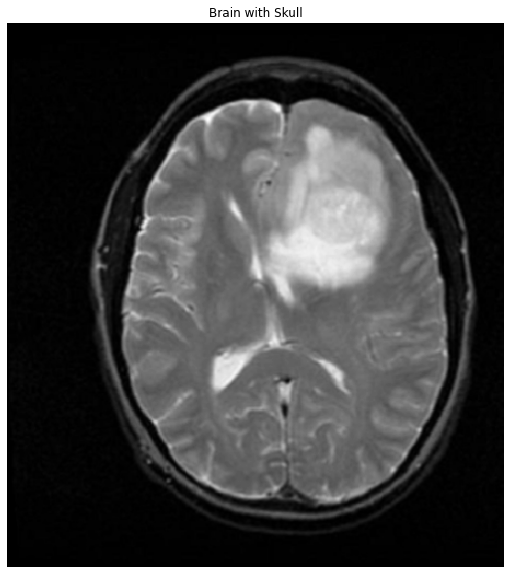

In [2]:
#Read in image
img  = cv2.imread('brain.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ShowImage('Brain with Skull',gray,'gray')

We would like to remove the skull from the image and leave only the brain behind.

# Extracting a Mask

If the pixels in the image can be classified into two different intensity classes, that is, if they have a bimodal histogram, then [Otsu's method](https://en.wikipedia.org/wiki/Otsu%27s_method) can be used to threshold them into a binary mask. Let's check that assumption.

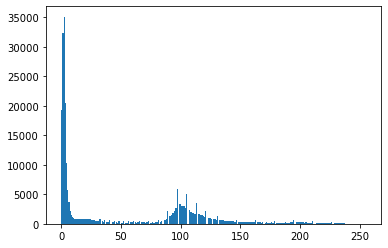

In [3]:
    #Make a histogram of the intensities in the grayscale image
    plt.hist(gray.ravel(), 256)
    plt.show()

Okay, the data is nicely bimodal. Let's apply the threshold and see how we do.

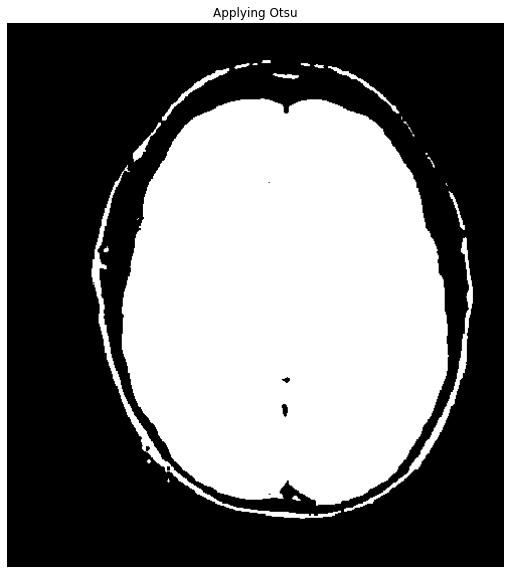

In [4]:
#Threshold the image to binary using Otsu's method
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
ShowImage('Applying Otsu',thresh,'gray')

Things are easier to see if we overlay our mask onto the original image

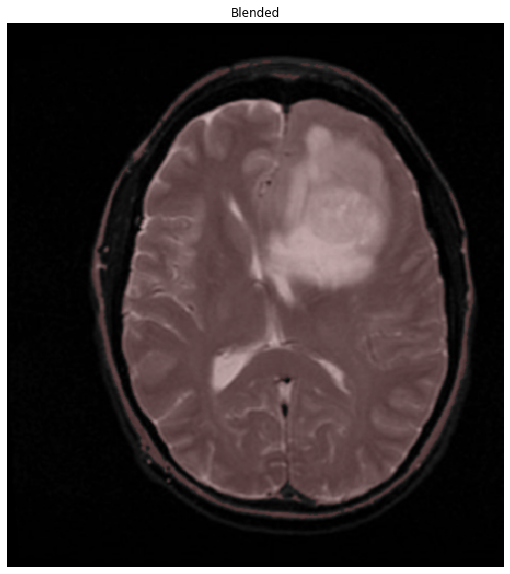

In [5]:
colormask = np.zeros(img.shape, dtype=np.uint8)
colormask[thresh!=0] = np.array((0,0,255))
blended = cv2.addWeighted(img,0.7,colormask,0.1,0)
ShowImage('Blended', blended, 'bgr')

# Extracting the Brain

The overlap of the brain (shown in red) with the mask is so perfect, that we'll stop right here. To do so, let's extract the connected components and find the largest one, which will be the brain.

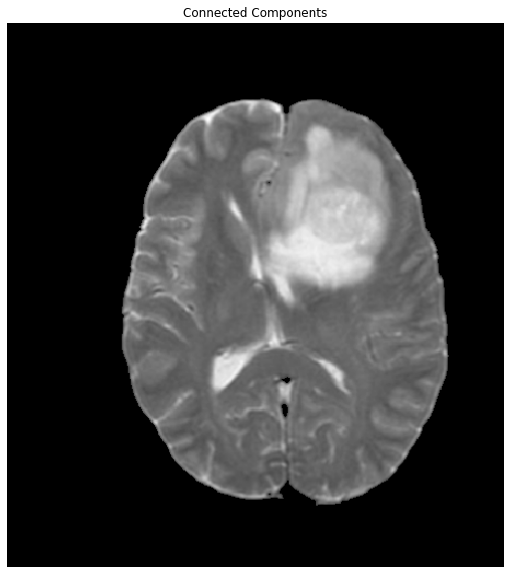

In [6]:
ret, markers = cv2.connectedComponents(thresh)

#Get the area taken by each component. Ignore label 0 since this is the background.
marker_area = [np.sum(markers==m) for m in range(np.max(markers)) if m!=0] 
#Get label of largest component by area
largest_component = np.argmax(marker_area)+1 #Add 1 since we dropped zero above                        
#Get pixels which correspond to the brain
brain_mask = markers==largest_component

brain_out = img.copy()
#In a copy of the original image, clear those pixels that don't correspond to the brain
brain_out[brain_mask==False] = (0,0,0)
ShowImage('Connected Components',brain_out,'rgb')

# Considering the Second Brain

Running this again with your second image produces a mask with many holes, probably because the image is of _much_ lower resolution:

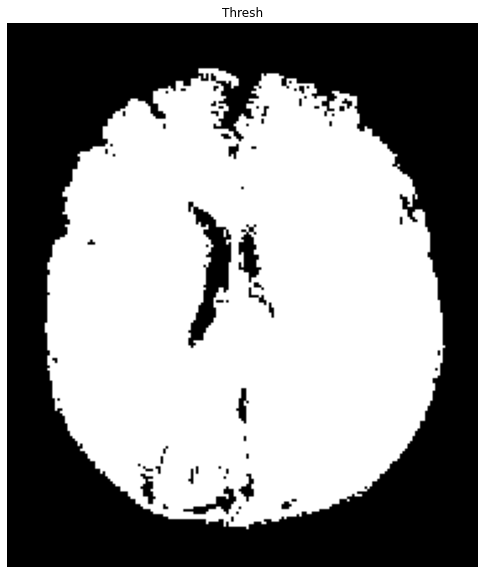

In [7]:
#Read in image
img  = cv2.imread('brain2.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#Threshold the image to binary using Otsu's method
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)

colormask = np.zeros(img.shape, dtype=np.uint8)
colormask[thresh!=0] = np.array((0,0,255))

ret, markers = cv2.connectedComponents(thresh)

#Get the area taken by each component. Ignore label 0 since this is the background.
marker_area = [np.sum(markers==m) for m in range(np.max(markers)) if m!=0] 
#Get label of largest component by area
largest_component = np.argmax(marker_area)+1 #Add 1 since we dropped zero above                        
#Get pixels which correspond to the brain
brain_mask = markers==largest_component

ShowImage('Thresh', brain_mask, 'gray')

We can close many of these holes using a [closing transformation](https://en.wikipedia.org/wiki/Closing_(morphology)):

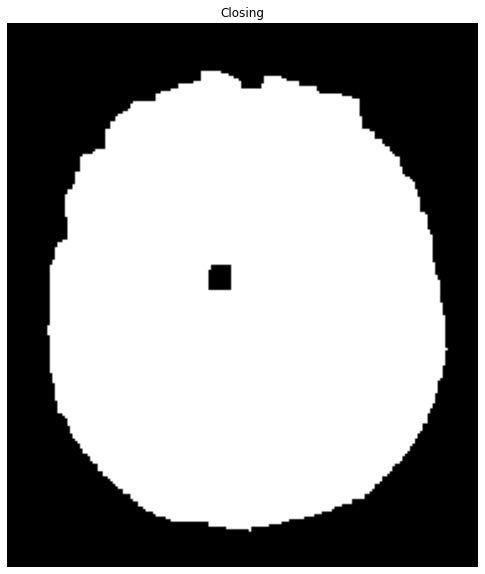

In [8]:
brain_mask = np.uint8(brain_mask)
kernel = np.ones((8,8),np.uint8)
closing = cv2.morphologyEx(brain_mask, cv2.MORPH_CLOSE, kernel)
ShowImage('Closing', closing, 'gray')

We can now extract the brain:

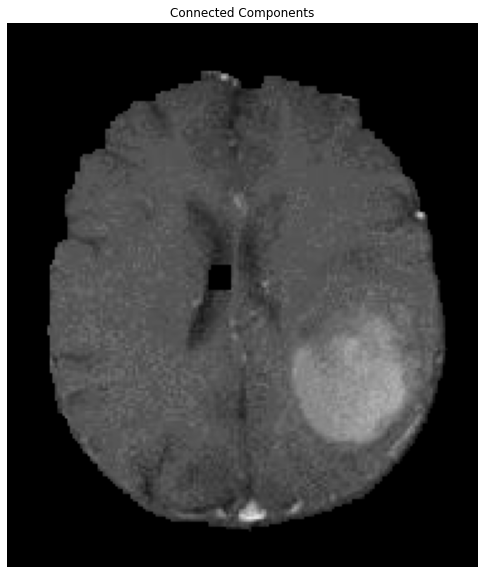

In [9]:
brain_out = img.copy()
#In a copy of the original image, clear those pixels that don't correspond to the brain
brain_out[closing==False] = (0,0,0)
ShowImage('Connected Components',brain_out,'rgb')